<a href="https://colab.research.google.com/github/Catarinatorres/spotify_unidade2/blob/main/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Redes - UFRN
Exercício Unidade 2

In [ ]:
!pip install nxviz=='0.6.3'

#1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import count
import json 
import matplotlib.pyplot as plt
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.patches as mpatches
import seaborn as sns


#2. Download the dataset and prepare the data

In [ ]:
#download the dataset
!gdown https://drive.google.com/u/0/uc?id=1caGQdAEo4iEEKYyCQd_hSXb5bfsasIKr&export=download

data = json.load(open('mpd.slice.549000-549999.json'))

#just colect the useful data
tamanho_playlists = len(data['playlists'])
num_playlist = []
num_tracks = []
artista = []
number = []

for i in range(0, tamanho_playlists):
  z = len(data['playlists'][i]['tracks'])
  number.append(str(i))
  for l in range(0, z):
    num_playlist.append(i)
    num_tracks.append(l)
    artista.append(data['playlists'][i]['tracks'][l]['artist_name'])

df = pd.DataFrame([number, num_playlist, num_tracks, artista]).T
df.columns = ['number','num_playlist', 'num_tracks','artista']
df['artista'] = df['artista'].astype(str).str.replace('\$\$',' x')

# as we are using a big dataset, we decided limit them by the playlists numbers, to make easer understand the analisys
# but you can change them adding or removing playlists
max_playlist = 3
df_mask=df['num_playlist']<=max_playlist
df = df[df_mask]


Downloading...
From: https://drive.google.com/u/0/uc?id=1caGQdAEo4iEEKYyCQd_hSXb5bfsasIKr
To: /content/mpd.slice.549000-549999.json
100% 34.7M/34.7M [00:00<00:00, 131MB/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
df_pesos = df.groupby(['num_playlist', 'artista']).size().reset_index(name='weight')
df_pesos

,num_playlist,artista,weight
0,0,*NSYNC,1
1,0,Aerosmith,1
2,0,Ariana Grande,1
3,0,Bee Gees,1
4,0,Billy Joel,3
...,...,...,...
144,3,Watsky,1
145,3,Wei Congfei,1
146,3,X Ambassadors,1
147,3,XXXTENTACION,1


#2.1 Create the network

In [ ]:
g = nx.Graph()
g.add_nodes_from(df_pesos['artista'])

In [ ]:
#create the network
G = nx.from_pandas_edgelist(
    df_pesos,
    'artista',
    'num_playlist',
    edge_attr='weight',
    create_using=nx.Graph()
)
# Export to graphml
nx.write_graphml(G, 'spotify.graphml')

#3. Data analisys

#3.1 Run the graphml create on step 2.1

In [ ]:
# source: /content/spotify.graphml
g = nx.read_graphml('spotify.graphml')


#3.2 Plot the network

Some playlists are disconnected. In this case, we are working just with four playlists (number 0, 1, 2, 3). When we plot the network, we can see the disconnected node. This is important to understand why the number of playlists are different from the number of plyalists in the network plotted latter.

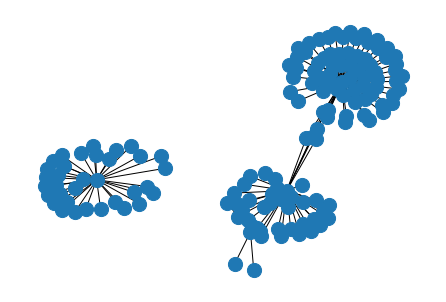

In [ ]:
nx.draw(g, node_size=200, pos=nx.spring_layout(g, k=0.2))

#3.3 Plot 

Some artists are conecting differents playlists. In this case, we can see that Jay Z are conecting the playlist number 0 to playlist number 1. And the conection between playlist number 0 and 2 is made by Brad Paisley, we find this using the shortest path between playlist 0 to 2: nx.shortest_path(g, source='0', target='2').

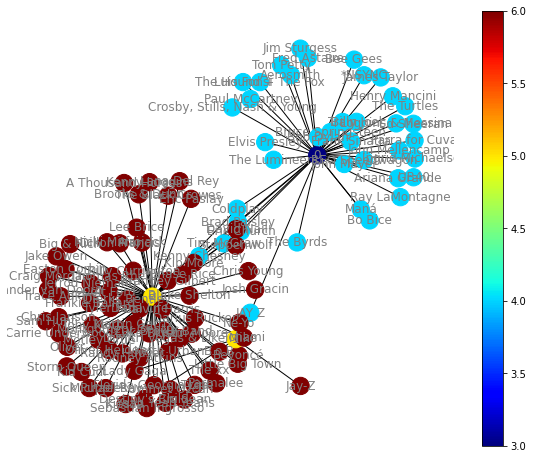

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)

# as some playlists are disconnected, is necessary to make them connected, using subgraphs
# this code will collect the largest component of this network and create a giant subgraph 

try:
  # color of nodes based on eccentricity
  color = list(dict(nx.eccentricity(g)).values())
except:
  comps=sorted(nx.connected_components(g),
               key=len, reverse=True)
  nodes_in_giant_comp = comps[0]
  g = nx.subgraph(g, nodes_in_giant_comp)
  # color of nodes based on eccentricity
  color = list(dict(nx.eccentricity(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos, 
                       alpha=1, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color, 
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eccentricity.png', transparent=True,dpi=400)
plt.show()


In [ ]:
nx.shortest_path(g, source='0', target='2')

['0', 'Brad Paisley', '2']

Playlist number 2 has the most number of artist conected to it. And the follow artists are more conected to others artists:

In [ ]:
print([k for k,v in nx.betweenness_centrality(g).items() if v != 0 and k !='1' and k !='2' and k !='0'])

['Brad Paisley', 'Coldplay', 'Eric Church', 'JAY Z', 'Kenny Chesney', 'Tim McGraw']


The maximum distance between two nodes is defined as eccentricity, in this case, the eccentricity of the network is 6. Observe that the most distance between nodes launches from singers in playlist 1 (Destini's Child, Beyoncé, Jay-Z, Lady Gaga), passing by playlist 1 to JAY Z(possible this is the same Jay-Z, writte incorrectly), going to playlist 0 wich is conect to singers in playlist 2 and finishing in others singers in playlist 2.

In [ ]:
# the diameter of networks is the maximum eccentricy
print("Diameter of network (g): {}".format(nx.diameter(g)))
print(nx.eccentricity(g))
# whom are in the diamter
print([k for k,v in nx.eccentricity(g).items() if v == nx.diameter(g)])

Diameter of network (g): 6
{'*NSYNC': 4, '0': 3, 'Aerosmith': 4, 'Ariana Grande': 4, 'Bee Gees': 4, 'Billy Joel': 4, 'Bo Bice': 4, 'Bob Dylan': 4, 'Brad Paisley': 4, 'Bruce Springsteen': 4, 'Coldplay': 4, 'Crosby, Stills, Nash & Young': 4, 'Ed Sheeran': 4, 'Elvis Presley': 4, 'Eric Church': 4, 'Frank Sinatra': 4, 'Fred Astaire': 4, 'Henry Mancini': 4, 'Ingrid Michaelson': 4, 'JAY Z': 4, 'James Taylor': 4, 'Jim Sturgess': 4, 'John Mayer': 4, 'John Mellencamp': 4, 'Kenny Chesney': 4, 'Loggins & Messina': 4, 'Luis Fonsi': 4, 'Maná': 4, 'Parra for Cuva': 4, 'Paul McCartney': 4, 'REO Speedwagon': 4, 'Ray LaMontagne': 4, 'The Byrds': 4, 'The Hound + The Fox': 4, 'The Lumineers': 4, 'The Turtles': 4, 'Tim McGraw': 4, 'Tom Petty': 4, 'Train': 4, 'UB40': 4, 'Beyoncé': 6, '1': 5, "Destiny's Child": 6, 'Jay-Z': 6, 'Lady Gaga': 6, 'A Thousand Horses': 6, '2': 5, 'Afrojack': 6, 'B.o.B': 6, 'Big & Rich': 6, 'Big Sean': 6, 'Billy Currington': 6, 'Blake Shelton': 6, 'Brantley Gilbert': 6, 'Brooks & Du

In [ ]:
# the periphery of a network is a set of all nodes whose eccentriciy is equals the diameter
nx.periphery(g)

['Beyoncé',
 "Destiny's Child",
 'Jay-Z',
 'Lady Gaga',
 'A Thousand Horses',
 'Afrojack',
 'B.o.B',
 'Big & Rich',
 'Big Sean',
 'Billy Currington',
 'Blake Shelton',
 'Brantley Gilbert',
 'Brooks & Dunn',
 'Calvin Harris',
 'Carrie Underwood',
 'Chase Rice',
 'Chris Janson',
 'Chris Young',
 'Colt Ford',
 'Craig Morgan',
 'Dada Life',
 'Darius Rucker',
 'David Nail',
 'Dierks Bentley',
 'Dillon Francis',
 'Dimitri Vegas & Like Mike',
 'Easton Corbin',
 'Eric Paslay',
 'Florida Georgia Line',
 'Frankie Ballard',
 'Jake Owen',
 'Jerrod Niemann',
 'Josh Gracin',
 'Justin Moore',
 'Keith Urban',
 'Kenny Loggins',
 'Kid Cudi',
 'Kiesza',
 'Kip Moore',
 'Lana Del Rey',
 'Lee Brice',
 'Little Big Town',
 'Luke Bryan',
 'Martin Garrix',
 'Michael Ray',
 'Montgomery Gentry',
 'Mötley Crüe',
 'Ne-Yo',
 'Nicki Minaj',
 'Oliver',
 'Oliver Heldens',
 'Parmalee',
 'Randy Houser',
 'Rodney Atkins',
 'Sam Hunt',
 'Sander van Doorn',
 'Sebastian Ingrosso',
 'Sick Puppies',
 'Steppenwolf',
 'Storm Que

The playlist 0 is the network center, wich radius is equal to 3.

In [ ]:
# the radius of a network is the minimum eccentricity
print("Radius of network(g): {}".format(nx.radius(g)))
print([k for k,v in nx.eccentricity(g).items() if v == nx.radius(g)])

Radius of network(g): 3
['0']


In [ ]:
# the center of a network is a set all nodes whose eccentricity equal the radius
nx.center(g)

['0']

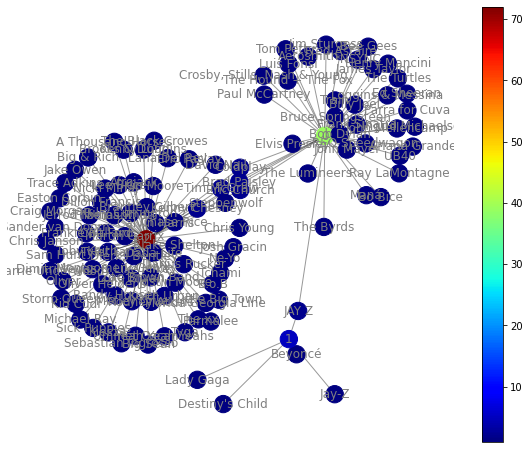

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree.png', transparent=True,dpi=300)
plt.show()

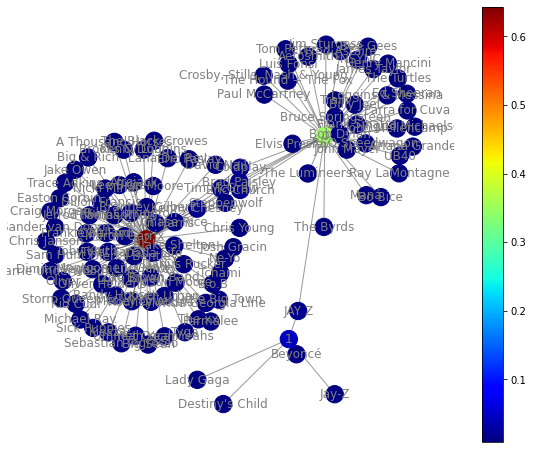

In [ ]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree_centrality.png', transparent=True,dpi=300)
plt.show()

In [ ]:
nx.degree_centrality(g)

{'*NSYNC': 0.008928571428571428,
 '0': 0.3482142857142857,
 '1': 0.04464285714285714,
 '2': 0.6428571428571428,
 'A Thousand Horses': 0.008928571428571428,
 'Aerosmith': 0.008928571428571428,
 'Afrojack': 0.008928571428571428,
 'Ariana Grande': 0.008928571428571428,
 'B.o.B': 0.008928571428571428,
 'Bee Gees': 0.008928571428571428,
 'Beyoncé': 0.008928571428571428,
 'Big & Rich': 0.008928571428571428,
 'Big Sean': 0.008928571428571428,
 'Billy Currington': 0.008928571428571428,
 'Billy Joel': 0.008928571428571428,
 'Blake Shelton': 0.008928571428571428,
 'Bo Bice': 0.008928571428571428,
 'Bob Dylan': 0.008928571428571428,
 'Brad Paisley': 0.017857142857142856,
 'Brantley Gilbert': 0.008928571428571428,
 'Brooks & Dunn': 0.008928571428571428,
 'Bruce Springsteen': 0.008928571428571428,
 'Calvin Harris': 0.008928571428571428,
 'Carrie Underwood': 0.008928571428571428,
 'Chase Rice': 0.008928571428571428,
 'Chris Janson': 0.008928571428571428,
 'Chris Young': 0.008928571428571428,
 'Coldp

In [ ]:
nx.closeness_centrality(g)

{'*NSYNC': 0.30517711171662126,
 '0': 0.4375,
 '1': 0.24347826086956523,
 '2': 0.56,
 'A Thousand Horses': 0.36012861736334406,
 'Aerosmith': 0.30517711171662126,
 'Afrojack': 0.36012861736334406,
 'Ariana Grande': 0.30517711171662126,
 'B.o.B': 0.36012861736334406,
 'Bee Gees': 0.30517711171662126,
 'Beyoncé': 0.19614711033274956,
 'Big & Rich': 0.36012861736334406,
 'Big Sean': 0.36012861736334406,
 'Billy Currington': 0.36012861736334406,
 'Billy Joel': 0.30517711171662126,
 'Blake Shelton': 0.36012861736334406,
 'Bo Bice': 0.30517711171662126,
 'Bob Dylan': 0.30517711171662126,
 'Brad Paisley': 0.48484848484848486,
 'Brantley Gilbert': 0.36012861736334406,
 'Brooks & Dunn': 0.36012861736334406,
 'Bruce Springsteen': 0.30517711171662126,
 'Calvin Harris': 0.36012861736334406,
 'Carrie Underwood': 0.36012861736334406,
 'Chase Rice': 0.36012861736334406,
 'Chris Janson': 0.36012861736334406,
 'Chris Young': 0.36012861736334406,
 'Coldplay': 0.48484848484848486,
 'Colt Ford': 0.3601286

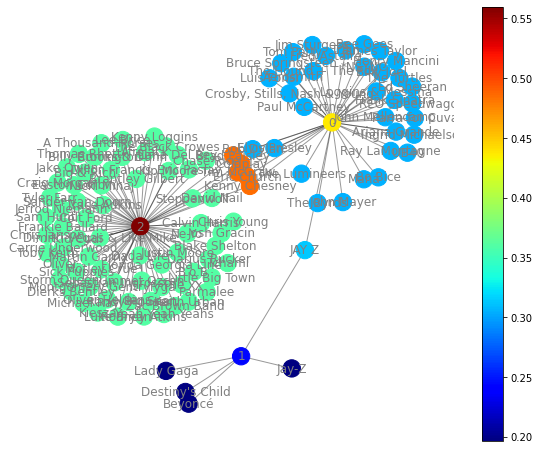

In [ ]:
# the closeness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.closeness_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('closeness_centrality.png', transparent=True,dpi=600)
plt.show()

In [ ]:
nx.betweenness_centrality(g)

{'*NSYNC': 0.0,
 '0': 0.5756113256113256,
 '1': 0.07046332046332046,
 '2': 0.8415379665379665,
 'A Thousand Horses': 0.0,
 'Aerosmith': 0.0,
 'Afrojack': 0.0,
 'Ariana Grande': 0.0,
 'B.o.B': 0.0,
 'Bee Gees': 0.0,
 'Beyoncé': 0.0,
 'Big & Rich': 0.0,
 'Big Sean': 0.0,
 'Billy Currington': 0.0,
 'Billy Joel': 0.0,
 'Blake Shelton': 0.0,
 'Bo Bice': 0.0,
 'Bob Dylan': 0.0,
 'Brad Paisley': 0.08751608751608755,
 'Brantley Gilbert': 0.0,
 'Brooks & Dunn': 0.0,
 'Bruce Springsteen': 0.0,
 'Calvin Harris': 0.0,
 'Carrie Underwood': 0.0,
 'Chase Rice': 0.0,
 'Chris Janson': 0.0,
 'Chris Young': 0.0,
 'Coldplay': 0.08751608751608755,
 'Colt Ford': 0.0,
 'Craig Morgan': 0.0,
 'Crosby, Stills, Nash & Young': 0.0,
 'Dada Life': 0.0,
 'Darius Rucker': 0.0,
 'David Nail': 0.0,
 "Destiny's Child": 0.0,
 'Dierks Bentley': 0.0,
 'Dillon Francis': 0.0,
 'Dimitri Vegas & Like Mike': 0.0,
 'Easton Corbin': 0.0,
 'Ed Sheeran': 0.0,
 'Elvis Presley': 0.0,
 'Eric Church': 0.08751608751608755,
 'Eric Paslay

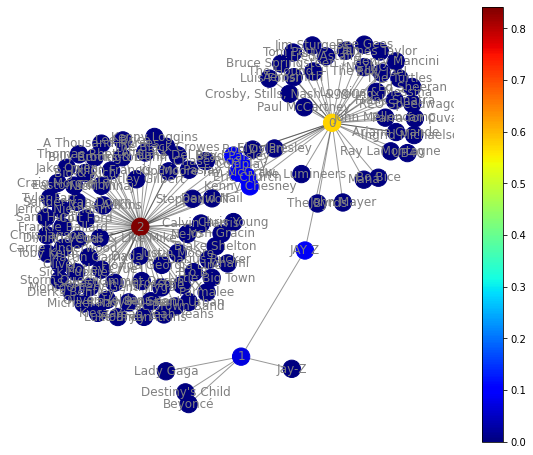

In [ ]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

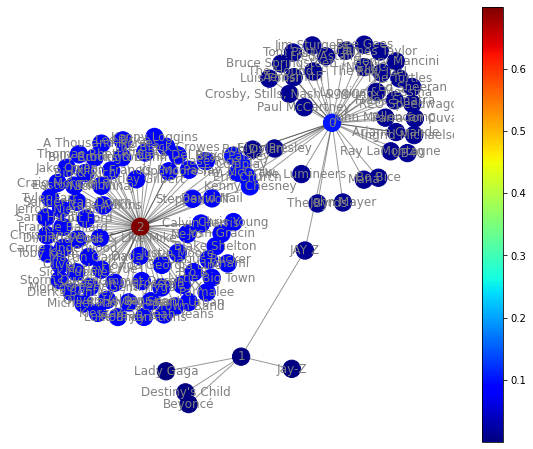

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

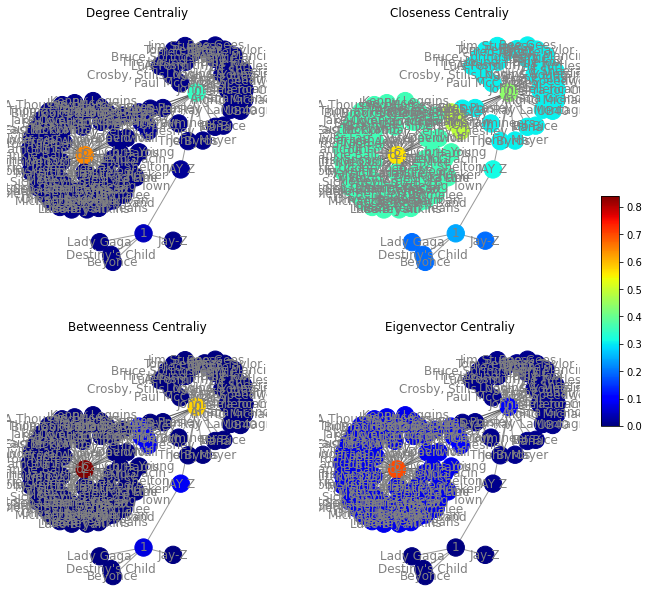

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(2,2,figsize=(10,8))

# max value of metrics 
max_centrality = max([max([v for k, v in nx.eigenvector_centrality(g).items()]),
                      max([v for k, v in nx.degree_centrality(g).items()]),
                      max([v for k, v in nx.closeness_centrality(g).items()]),
                      max([v for k, v in nx.betweenness_centrality(g).items()])])

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)

# color of nodes
color_degree = list(dict(nx.degree_centrality(g)).values())
color_closeness = list(dict(nx.closeness_centrality(g)).values())
color_betweenness = list(dict(nx.betweenness_centrality(g)).values())
color_eigenvector = list(dict(nx.eigenvector_centrality(g)).values())

# 
# draw edges
#
# degree centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[0,0])

# closeness centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[0,1])

# betweenness centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[1,0])

# eigenvector centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[1,1])

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_closeness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_betweenness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_eigenvector,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1])

# 
# draw labels
#
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax[0,0])
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax[0,1])
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax[1,0])
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax[1,1])

# eliminate axis
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[0,1].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("Degree Centraliy")
ax[0,1].set_title("Closeness Centraliy")
ax[1,0].set_title("Betweenness Centraliy")
ax[1,1].set_title("Eigenvector Centraliy")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)

plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

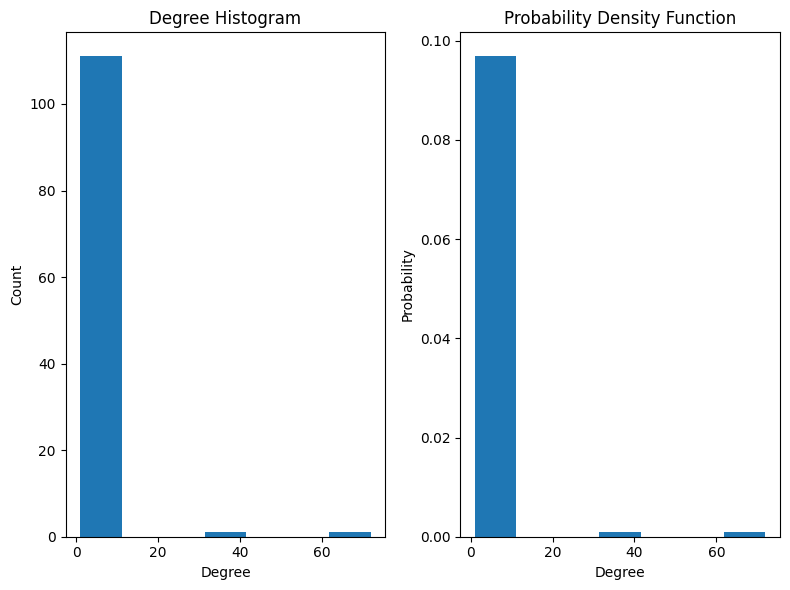

In [ ]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=7)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

In [ ]:
print(all_data)

(array([111.,   0.,   0.,   1.,   0.,   0.,   1.]), array([ 1.        , 11.14285714, 21.28571429, 31.42857143, 41.57142857,
       51.71428571, 61.85714286, 72.        ]), <BarContainer object of 7 artists>)


In [ ]:
# print the width of each bin
print(all_data[1])

[ 1.         11.14285714 21.28571429 31.42857143 41.57142857 51.71428571
 61.85714286 72.        ]


In [ ]:
# calc the width of each bin using numpy
# diff calc the difference between two positions in the array
bin_width = np.diff(all_data[1])
bin_width

array([10.14285714, 10.14285714, 10.14285714, 10.14285714, 10.14285714,
       10.14285714, 10.14285714])

In [ ]:
# total number of elements in array
all_data[0].sum()

113.0

In [ ]:
# probability density function for each bin
# please check the right figure above and compare the results
all_data[0]/(all_data[0].sum() * bin_width)

array([0.09684657, 0.        , 0.        , 0.00087249, 0.        ,
       0.        , 0.00087249])

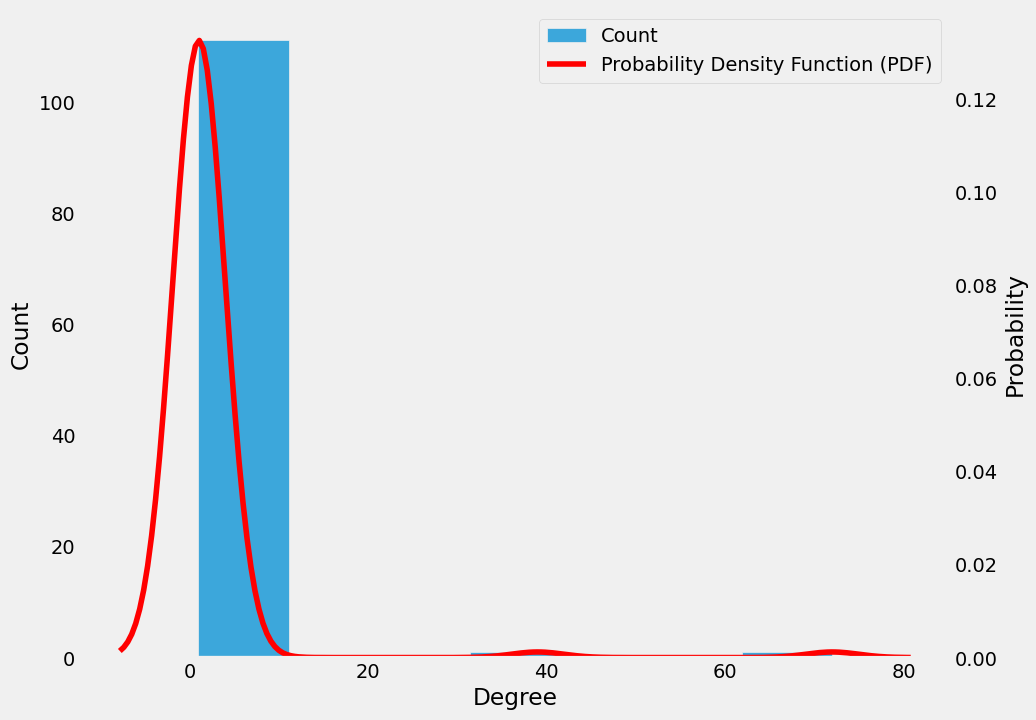

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

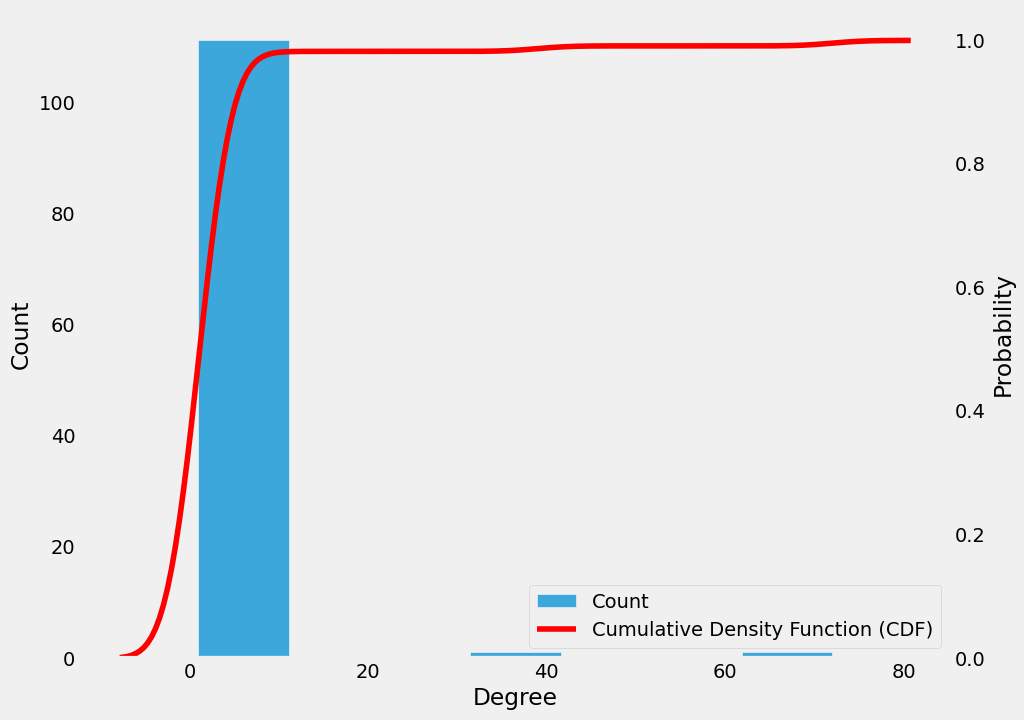

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

In [ ]:
plt.style.use("ggplot")

# Another way to visualize the cumulative distribution
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

def ecdf_degree(G):
    """ECDF of degree."""
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")

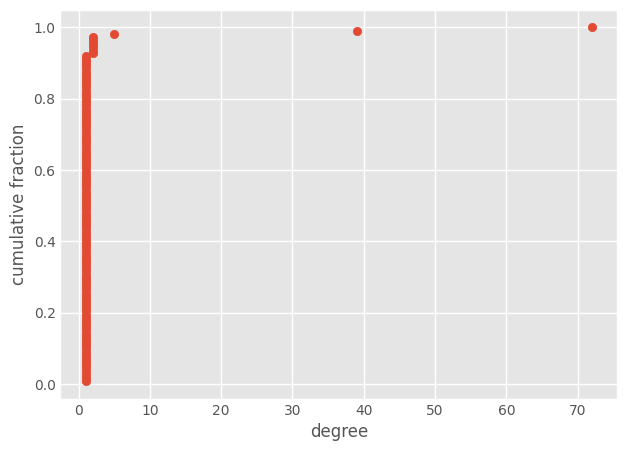

In [ ]:
#
# insighs
# cdf(1) - almore 40% of vertices has degree 1
# cdf(2) P(degree <= 2) - 50% of vertices has at least degree 2 or less
# cdf(6) P(degree <= 6) - more than 95% of vertices has at least degree 6 or less
ecdf_degree(g)

#Teste

In [ ]:
import re

df.loc[df.artista.str.contains('JAY Z', flags=re.I, regex=True)]

,number,num_playlist,num_tracks,artista
11,11,0,11,JAY Z
75,75,1,0,JAY Z
76,76,1,1,JAY Z
78,78,1,3,JAY Z
79,79,1,4,JAY Z
80,80,1,5,JAY Z
81,81,1,6,JAY Z
82,82,1,7,JAY Z
83,83,1,8,JAY Z
84,84,1,9,JAY Z


#fim do teste